## Hypothesis Testing for Lead/Lag Analysis with Daily Emotions and Migration

#### Author: Eliza Salamon

Importing and cleaning data

In [35]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
#get migration patterns
flow_df = pd.read_csv('hcr_dat_border.csv')
countries_of_interest = ['Slovakia', 'Hungary', 'Poland', 'Republic of Moldova']
flow_df = flow_df[flow_df.Country.isin(countries_of_interest)]
flow_df['data_date'] = pd.to_datetime(flow_df['data_date'], format='%d/%b/%Y')
flow_df.drop(columns=['iso3', 'Country'], inplace=True)
flow_df.rename(columns={"data_date": 'date', ' Border_Crossings ' : 'border_crossings'}, inplace=True)
flow_df['border_crossings'] = flow_df['border_crossings'].str.replace(',', '')
flow_df['border_crossings'] = flow_df['border_crossings'].str.replace('-', '0')
flow_df['border_crossings'] = flow_df['border_crossings'].str.strip().astype('int')
flow_df = flow_df.groupby(['date']).sum()
flow_df.head()

,border_crossings
date,
2022-02-24,65846
2022-02-25,90155
2022-02-26,131865
2022-02-27,154046
2022-02-28,149041


In [12]:
#get emotion data
df_emotion = pd.read_csv('../Indicators/Emotion/binary_predictions_2022.csv')
df_emotion.drop(columns=df_emotion.columns[0], inplace=True)
df_emotion['date'] = pd.to_datetime(df_emotion['date'], format='%Y-%m-%d')
df_emotion = df_emotion[df_emotion['predicted_emotion'] != 'others'] #comment this out if you want to include others in hyptothesis testing
df_emotion.head()

,date,city,tweet,predicted_emotion
2,2022-10-22,Хмельницький,RT @superumka: Луцьк і Хмельницький просять на...,joy
3,2022-10-22,Хмельницький,Хмельницький після вранішніх вибухів опинився ...,sadness
4,2022-10-22,Хмельницький,RT @tsnua: Хмельницький після вранішніх вибухі...,sadness
7,2022-10-22,Хмельницький,RT @superumka: Луцьк і Хмельницький просять на...,joy
8,2022-10-22,Миколаїв,"RT @OlenaBek60: Миколаїв без світла, але у Каш...",joy


In [13]:
#group by emotion count
df_emotion = df_emotion.groupby(['date', 'predicted_emotion']).count()
df_emotion.drop(columns=['city'], inplace=True)

In [14]:
merged_df = flow_df.merge(df_emotion, left_index=True, right_index=True, how='inner')
merged_df.head()

border_crossings  tweet
date       predicted_emotion                         
2022-02-24 joy                           65846      6
           sadness                       65846      1
2022-02-25 anger                         90155     14
           fear                          90155      5
           joy                           90155     14

In [15]:
#reindex so all emotion/date combos are present
all_dates = pd.date_range(np.min(merged_df.index.get_level_values('date')), np.max(merged_df.index.get_level_values('date')))
all_emotions = list(set(merged_df.index.get_level_values('predicted_emotion')))
ind2 = pd.MultiIndex.from_product([all_dates,all_emotions], names = ['date','emotion'])
merged_df = merged_df.reindex(ind2, fill_value = 0) 
merged_df.index = merged_df.index.set_levels([pd.to_datetime(merged_df.index.levels[0]), merged_df.index.levels[1]])
merged_df.drop(columns=['border_crossings'], inplace=True)
merged_df.head()

tweet
date       emotion       
2022-02-24 fear         0
           anger        0
           joy          6
           sadness      1
2022-02-25 fear         5

In [16]:
#graphing colors
emotions_colors  = {
    "anger": "#8A0000",
    "fear": "#B57EDC",
    "sadness": "#0000FF",
    "disgust": "#006400",
    "joy": "#FFD700",
    "others": "black"
}

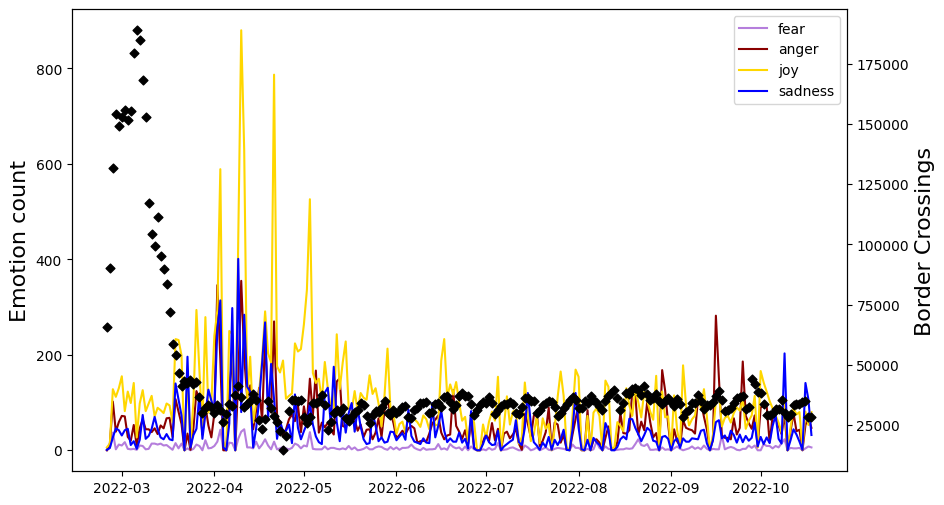

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
ax2 = ax.twinx()
for r in all_emotions:
    ax.plot(merged_df.xs(r,level=1).loc[:,'tweet'], label = r, color=emotions_colors[r])
ax2.scatter(flow_df.index.values, flow_df.border_crossings.values, color='black', marker='D', s=20)
ax.set_ylabel('Emotion count', fontsize=16)
ax2.set_ylabel('Border Crossings', fontsize=16)
ax.legend()

## Correlations for lead/lag with raw counts

In [18]:
offset_range = np.arange(-14, 14)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
emotions = all_emotions.copy()
# #emotions.remove('others')

for i in offset_range:
    for e in emotions:
            shift = merged_df.xs(e,level=1).loc[:,'tweet'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr)

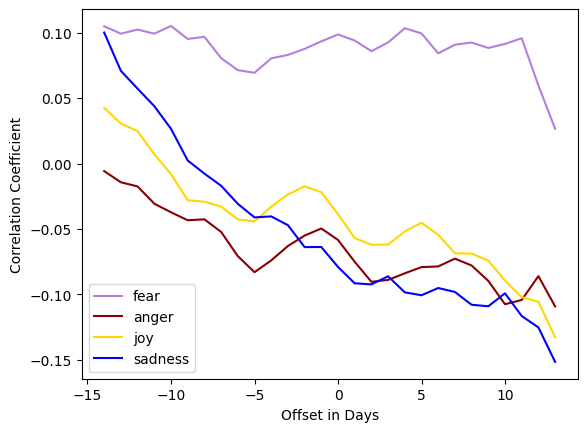

In [19]:
#graph all correlations from -2 weeks to +2 weeks 
fig = plt.figure()
for i in emotions:
    plt.plot(offset_range, corr_dict[i], label=i, color=emotions_colors[i])
plt.xlabel('Offset in Days')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.show()

Lead Lag clarification:  

positive shift (leading indicator) 
Emotions predicting migration: At around 2 weeks before migration, tweets have negative correlations except fear (may be valuable to predict later migration)

negative shift (lagging indicator)
Migration predicting emotions: Positive relationship the further apart migration and emotion get
note: the bigger the absolute value of the shift is, the less data points there are that line up which alone may increase correlations



In [20]:
offset_range = np.arange(0, 30)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in emotions:
            shift = merged_df.xs(e,level=1).loc[:,'tweet'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr)

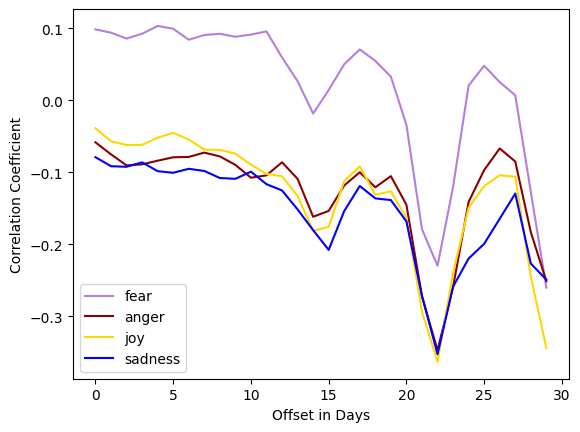

In [21]:
#graph all correlations to one month shift
fig = plt.figure()
for i in emotions:
    plt.plot(offset_range, corr_dict[i], label=i, color=emotions_colors[i])
plt.xlabel('Offset in Days')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.show()

## Correlations for lead/lag with proportions

In [22]:
merged_df['proportion'] = merged_df.groupby(level=0).apply(lambda x: x/x.sum())['tweet'].values
merged_df.head()

tweet  proportion
date       emotion                   
2022-02-24 fear         0    0.000000
           anger        0    0.000000
           joy          6    0.857143
           sadness      1    0.142857
2022-02-25 fear         5    0.131579

In [23]:
offset_range = np.arange(-14, 14)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in emotions:
            shift = merged_df.xs(e,level=1).loc[:,'proportion'].shift(i)
            print(shift)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr)

date
2022-02-24    0.017143
2022-02-25    0.066351
2022-02-26    0.069652
2022-02-27    0.067039
2022-02-28    0.079096
                ...   
2022-10-14         NaN
2022-10-15         NaN
2022-10-16         NaN
2022-10-17         NaN
2022-10-18         NaN
Freq: D, Name: proportion, Length: 237, dtype: float64
date
2022-02-24    0.251429
2022-02-25    0.180095
2022-02-26    0.228856
2022-02-27    0.189944
2022-02-28    0.293785
                ...   
2022-10-14         NaN
2022-10-15         NaN
2022-10-16         NaN
2022-10-17         NaN
2022-10-18         NaN
Freq: D, Name: proportion, Length: 237, dtype: float64
date
2022-02-24    0.560000
2022-02-25    0.540284
2022-02-26    0.353234
2022-02-27    0.497207
2022-02-28    0.474576
                ...   
2022-10-14         NaN
2022-10-15         NaN
2022-10-16         NaN
2022-10-17         NaN
2022-10-18         NaN
Freq: D, Name: proportion, Length: 237, dtype: float64
date
2022-02-24    0.171429
2022-02-25    0.213270
2022-02-26

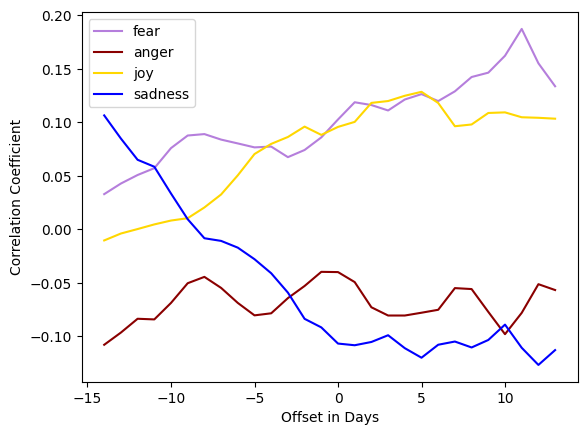

In [24]:
fig = plt.figure()
for i in emotions:
    plt.plot(offset_range, corr_dict[i], label=i, color=emotions_colors[i])
plt.xlabel('Offset in Days')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.show()

In [25]:
unstacked_prop = merged_df['proportion'].unstack(level=1)
correlations = pd.concat([unstacked_prop,flow_df['border_crossings']], axis=1).corr()['border_crossings']
print(correlations)

anger              -0.040011
fear                0.102484
joy                 0.095544
sadness            -0.106747
border_crossings    1.000000
Name: border_crossings, dtype: float64


## Correlation for lead/lag with difference from mean

In [26]:
merged_df['mean_diff'] = merged_df['tweet'] - merged_df.groupby(level=0).mean()['tweet']
merged_df.head()

tweet  proportion  mean_diff
date       emotion                              
2022-02-24 fear         0    0.000000      -1.75
           anger        0    0.000000      -1.75
           joy          6    0.857143       4.25
           sadness      1    0.142857      -0.75
2022-02-25 fear         5    0.131579      -4.50

In [27]:
offset_range = np.arange(-14, 14)
corr_dict = {'joy':[], 'anger':[], 'fear': [], 'sadness': [], 'others':[]}
for i in offset_range:
    for e in emotions:
            shift = merged_df.xs(e,level=1).loc[:,'mean_diff'].shift(i)
            corr = shift.corr(flow_df['border_crossings'])
            corr_dict[e].append(corr)

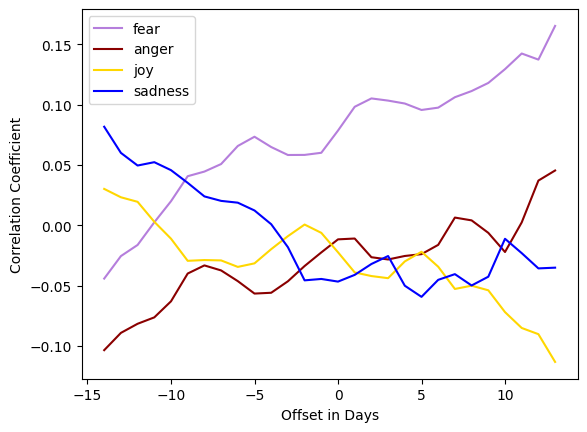

In [28]:
fig = plt.figure()
for i in emotions:
    plt.plot(offset_range, corr_dict[i], label=i, color=emotions_colors[i])
plt.xlabel('Offset in Days')
plt.ylabel('Correlation Coefficient')
plt.legend()
plt.show()

In [30]:
def corrMat(covars, responses, df):
    corrMat = pd.DataFrame(columns=covars, index=responses)
    for c2 in covars:
        for c1 in responses:
            corrMat.at[c1, c2] = df[c2].corr(df[c1])
    return corrMat

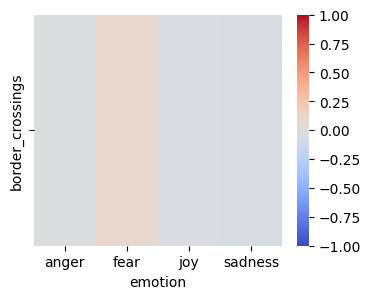

In [41]:
unstacked_mean = merged_df['mean_diff'].unstack(level=1)
correlations = pd.concat([unstacked_mean,flow_df['border_crossings']], axis=1)
cm = corrMat(unstacked_mean.columns, ['border_crossings'], correlations)
plt.figure(figsize=(4, 3))
sns.heatmap(cm.astype(float), annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()